# Report 22/10/2022

## Introduction
In this notebook I will go through the problems we identified in the last meeting. Broadly, there are two problems with the current model fitting approach that we need to fix.
1. Evaluating Model performance: How do we evaluate model performance beyond simple coherence measures
2. Interpretation of topics: How do we make sure the model gives us the topics we want (i.e. not all medical science).


## Notebook Outline:
- Model performance
    - Coherence scores
    - Distribution of documents per topic 
    - Perplexity (held-out probabilities)
 
</p>

- Interpretation of topics
    - Key words

In [146]:
# import packages
import xml.etree.ElementTree as ET
import numpy as np
import seaborn as sns
import pandas as pd

### Model performance

Our general problem here is how to best evaluate model performance. This is most important as the LDA requires us to select the number of topics as a parameter in the model. There is no clear way to set this value so it is important to have a quantitative way to say which number of topics is best. There are several metrics which can do this which I explore here. 

#### Coherence scores

Coherence is an measure of the degree to which the topics identifed by the LDA are consistent with themselves. It effectively measures the degree to which words in the same topic also tend to occur together in the same documents in the corpus (the total collection of text, our titles and abstracts). 

Coherence is automatically generated by the `mallet` program as per the documentation:

" **Coherence.** This metric measures whether the words in a topic tend to co-occur together. We add up a score for each distinct pair of top ranked words. The score is the log of the probability that a document containing at least one instance of the higher-ranked word also contains at least one instance of the lower-ranked word.
$$
∑i∑j<ilogD(wj,wi)+βD(wi)
$$
To avoid log zero errors we add the "beta" topic-word smoothing parameter specified when you calculate diagnostics. Since these scores are log probabilities they are negative. Large negative values indicate words that don't co-occur often; values closer to zero indicate that words tend to co-occur more often. "


<AxesSubplot:xlabel='n_topics', ylabel='coherence_score'>

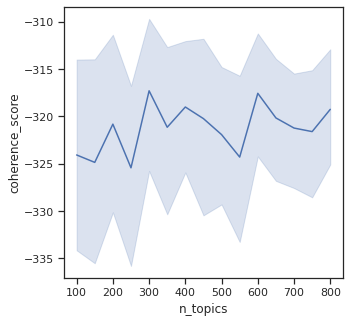

In [161]:
#Create empty dictionary to store values of coherence scores and topics
coh_means = {"n_topics":[], "coherence_score":[]}

# Calculate the average coherence scores for a given topic model using the individual topic coherence from the diagnostic files
# created by Mallet when fitting the LDA model for each number of topics. We stored values in the previously created dictionary.

for i in range(100,801,50):
    tree = ET.parse('../results/fine-scale/mallet-models/ENG-speaking-countries/'+str(i)+'-topics-diagnostics.xml')
    root = tree.getroot()

    #mean coherence
    c = [float(child.attrib['coherence']) for child in root]
    for j in c:
        coh_means["coherence_score"].append(j)
        coh_means["n_topics"].append(i)

# Plot 
sns.set_theme(style="ticks")
sns.lineplot(x="n_topics", y="coherence_score", data=coh_means)

16 topic models ranging from 100 to 800 topics, at 50 intervals; y axis shows the UMass coherence score described above. Overall we can see that across 100-800 topics coherence is relatively vairable though maybe hints towards a positve trend? 


#### Distribution of documents per topic
Another way to look at possible performance is to look at the distribution of documents assigned to each topic. The general idea is that a model is performing bad if we have topics being assigned no documents. I have researched this in more detail and I'm not sure this is such a good method though. The reasoning is a little complex but i will explain in brief here. 

The LDA is based on two key Dirchlet distributions whose parameters $\alpha$ and $\beta$ control the distribution of topics per document and words per topic respectively. In the fitting process we let the values of $\alpha$ be optimised to fit the data in a non-symmetric way 
such that some topics will be favoured more than others. This lets the model account for the fact that not all topics are equally represented in the data and has been found to lead to more robust fits for the LDA model ([Wallach et. al.](https://mimno.infosci.cornell.edu/papers/NIPS2009_0929.pdf) 2009). The consequence of this is that the document-topic distribution is skewed such that not all topics are equally represented. Therefore, **uneveness in the document-topic distribution is not an indication of poor fits**. 



In [151]:
# Create dictionary to store a sample of the data from each model with topics varying from 100 to 800.
#  I used a sample because it takes too long to load all the data (> 2 million rows).

data = {"doc_id":[], "n_topics":[], "topic_id":[]}

#loop over topics

for i in range(100, 801, 50):
    #read doc_topic_matrix
    with open("/home/flavia/Projects/Funding-Landscape/results/fine-scale/mallet-models/ENG-speaking-countries/" +str(i)+ "-topics-doc.txt","r") as f:

            d = 0
            for line in f:

                # get the highest probability topic from each document 
                topic_id = np.argmax([float(x) for x in line.split()[2:]])
                data["topic_id"].append(topic_id)
                data["n_topics"].append(i)
                data["doc_id"].append(d)
                d += 1
                
                if d > 20000:
                    break
# Transform dictionary into dataframe
df = pd.DataFrame(data)

# Create a temporary dataframe to count the number of documents for each given topic and sort in descending order.
df_tmp = df.groupby(["n_topics", "topic_id"], as_index=False).size().reset_index()
df_tmp = df_tmp.drop(["index"],axis=1).sort_values(["n_topics","size"], ascending = False)
df_tmp["new_id"] = df_tmp.groupby("n_topics").cumcount()

# Join the temporary dataframe back to the original dataframe.
df_new = df_tmp.set_index(['n_topics','topic_id']).join(df.set_index(['n_topics','topic_id'])).reset_index()

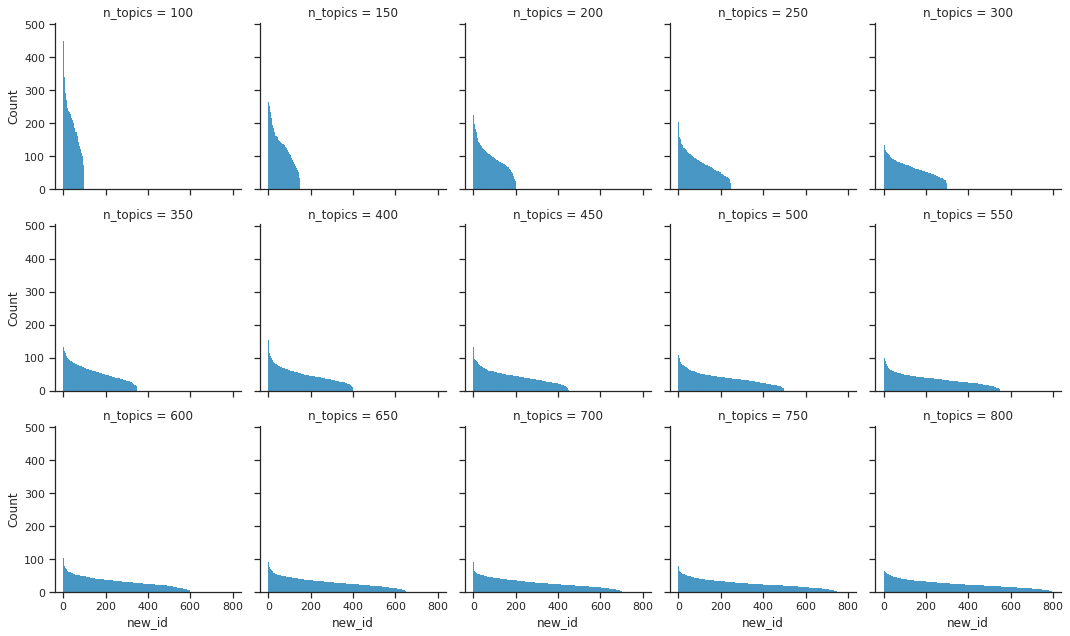

In [153]:
sns.set_theme(style="ticks")
sns.set_palette('colorblind')

# plt.figure(figsize=(5, 5))
# sns.set(rc={'figure.figsize':(5,5)})

sns.displot(data=df_new, x="new_id", col="n_topics", col_wrap=5, binwidth = 1, height=3)

Sorted document topic distributions. Each panel shows the distribution of documents assigned to each topic (x-axis) sorted by the most common topic to the least common for each model (i.e. model with 100 topics, model with 150 topics, model with 200 topics...).  **As expected, given the Dirichlet distribution with asymmetric prior for alpha,** the plots above show a higher concentration of documents over a smaller number of topics, and a smaller concentration of documents spread over a larger number of topics, as topic number increases. See [these slides](https://people.cs.umass.edu/~wallach/talks/priors.pdf) for an explanation on priors in LDA. 



#### Perplexity
The final (and perhaps most promising) option is using [perplexity](http://qpleple.com/perplexity-to-evaluate-topic-models/), the ability of the model to predict held-out data. This works by training the model on a subset of data and then asking it to predict the topics of new unseen data. If the model can predict this new data with a high confidence (as measured by the likelihood?) then we conculde that the model is performing well.

This method is implemented in the `mallet` program so should be fairly straightforward to implement. This will be my next step in solving the problem of ensuring the model is fitting well. 

### Interpretation of topics

The other problem we have is with the actual interpretation of the topics (i.e. what they mean). This is of course very subjective and there wont be a quantitative way to determine what each topic means. The main problem we have here is that as the data is very biased towards medical sciences (because of the size of the NIH program) the topics that we identify become very biased. This is a problem if we want to provide useful insight to the dean who presumably is interested mostly in STEM topics. One solution to this may be to increase the topic number. More topics means each topic becomes more specialised thus more likely to represent the non-medical topics of interest. 

#### Key words
To demonstrate this I show the occurence of specific words as I increase the number of topics fit to the data. 

<AxesSubplot:xlabel='n_topics', ylabel='relative_count'>

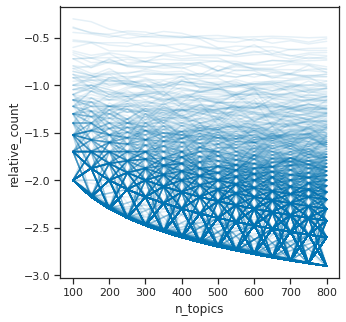

In [159]:
#Load occurences of word per topic.
data = {"n_topics":[], "word":[]}

for i in range(100, 801, 50):
    #read doc_topic_matrix
    with open("/home/flavia/Projects/Funding-Landscape/results/fine-scale/mallet-models/ENG-speaking-countries/" +str(i)+ "-topics-keys.txt","r") as f:
        for line in f:

                # get the highest probability topic from each document 
                tokens =  line.split()[2:]

                for word in tokens:
                    data["word"].append(word)
                    data["n_topics"].append(i)

df = pd.DataFrame(data)
df_plot = df.groupby(['n_topics', 'word'], as_index=False).size().reset_index()
df_plot["relative_count"] = np.log10(df_plot['size'] / df_plot['n_topics'])

sns.lineplot(data=df_plot, x="n_topics", y="relative_count", units="word", estimator=None, alpha = 0.1)

Relative count of words (log10) plotted over the number of topics. Each line shows the proportion of topics which contain a given word. This figure shows the relationship of which new words appear with increasing number of topics. Most words are rare but a few are very common and found in many topics. The curved shape occurs as it is the lower bound set by $\frac{1}{N_{\text{topics}}}$ (i.e. I dont plot words if they occur in topics less than 1 time). 

We can also plot specific words of interest to show how they emerge only at higher topic-numbers.

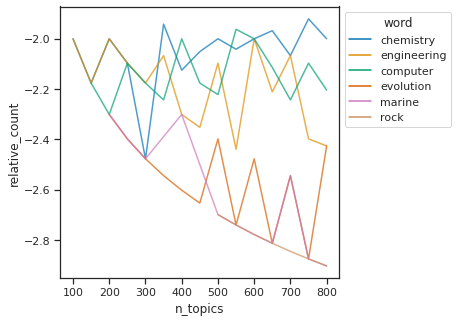

In [160]:
df_words = df_plot.query('word == ["engineering", "computer", "evolution", "chemistry", "marine", "rock"]')

plot = sns.lineplot(data=df_words, x="n_topics", y="relative_count", units="word", estimator=None, alpha = 0.7, hue='word')
sns.move_legend(plot, "upper left", bbox_to_anchor=(1, 1))

The relative count of example words (log10) over number of topics. 9 example words choosen to show how the increase in number of topics allows for new words/topics to appear. In the plot, only 6 words are being shown, as 'algebraic', 'physics' and 'ecology' haven't yet appeared It is possible that these words would appear in a model with higher number of topics (800+). 


The table below show the approximate number in which this words occurs in the input text and the mo

| Word        | Min occurrence in input text | Topic model in which word first appears |
|-------------|------------------------------|-----------------------------------------|
| engineering | 15,000                       | 100                                     |
| computer    | 13,000                       | 150                                     |
| evolution   | 12,000                       | 200                                     |
| chemistry   | 11,000                       | 250                                     |
| marine      | 5,000                        | 200                                     |
| rock        | 3,000                        | 500                                     |
| algebraic   | 2,000                        | hasn't appeared yet                     |
| physics     | 2,000                        | hasn't appeared yet                     |
| ecology     | 1,000                        | hasn't appeared yet                     |

#### Solutions

There are 2 possible solutions:

##### 1) Increase number of topics 
As we can see above new topics do appear as we increase the number of topics. It is possible that with enough topics we will get enough detail to identify the fields we are interested in. This seems like a shot in the dark though as there is no guarantee this will happen and the problem becomes very computationaly intensive as the number of topics increases (current model outputs are taking up ~400GB in Roy! 😱). 

##### 2) Cut the medical data 
I think the easiest solution is to separate the medical and STEM subjects. We can then do the analysis on STEM data and not have to worry about the relative size of the medical topics. If we have time/want to we can come back to the medical data. 